In [1]:
#数据准备与处理
from keras.preprocessing.image import ImageDataGenerator
IMSIZE = 224

#定义图片数据生成器，导入训练集的数据集
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './data_inception/train/',   #读取数据
    target_size=(IMSIZE,IMSIZE), #设置规定图片输出的大小
    batch_size=100,              #批处理大小为100
    class_mode='categorical')    #类的模型是'categorical'

#定义图片数据生成器，导入测试集的数据集
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './data_inception/test/',
    target_size=(IMSIZE,IMSIZE),
    batch_size=100,
    class_mode='categorical')

Found 952 images belonging to 17 classes.
Found 408 images belonging to 17 classes.


<Figure size 432x288 with 0 Axes>

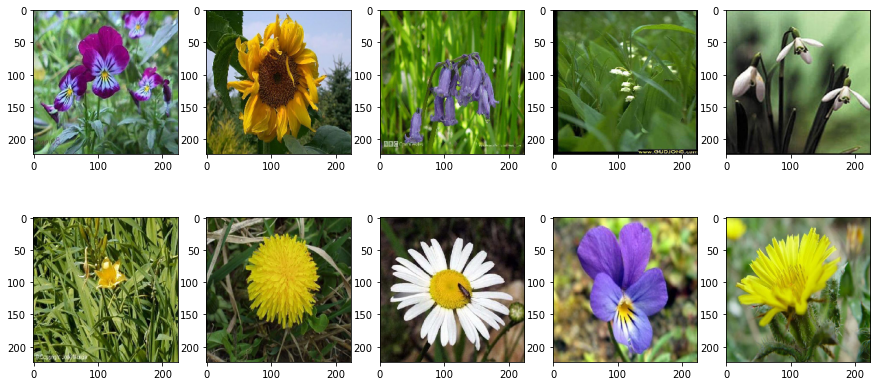

In [2]:
#展示图像
from matplotlib import pyplot as plt
plt.figure()
fig,ax = plt.subplots(2,5)  #定义一个2行5列的显示框图
fig.set_figheight(7)        #显示图的高为6
fig.set_figwidth(15)        #显示图的宽为15
ax = ax.flatten()
X,Y = next(train_generator)
for i in range(10):        #随机选择数据集中10张图片来显示
    ax[i].imshow(X[i,:,:,:])

In [3]:
#导入需要的包
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D
#concatenate该函数由于实现同一层中不同尺寸卷积核的并联操作
from keras.layers import Flatten,Dropout,Dense,Input,concatenate
from keras import Model
import tensorflow as tf
from tensorflow.keras import Sequential

IMSIZE = 224
#输入为224*224*3
input_layer = Input([IMSIZE,IMSIZE,3])
x=input_layer

#第1层卷积层。7*7的卷积核（滑动步长为2）进行same卷积，激活函数为relu，64通道，输出为112*112*64
x=Conv2D(64,(7,7),strides=(2,2),padding='same',activation='relu')(x)
#BatchNormalization用来提高分类的准确率
x=BatchNormalization(axis=3)(x)
#3*3的最大值池化（步长为2），输出尺寸为112/2=56，即56*56*64
x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

#第2层卷积层。3*3的卷积核（滑动步长为1）进行same卷积，激活函数为relu，192通道，输出为56*56*192
x=Conv2D(192,(3,3),strides=(1,1),padding='same',activation='relu')(x)
x=BatchNormalization(axis=3)(x)
#3*3的最大值池化（步长为2），输出尺寸为56/2=28，即28*28*192
x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

#第3层（Inception 3a层）。有4个分支，采用不同 尺寸的卷积核进行处理
for i in range(9):
    #64个1*1的卷积核，输出为28*28*64.
    branch1x1 = Conv2D(64,(1,1),strides=(1,1),padding='same',activation='relu')(x)
    branch1x1 = BatchNormalization(axis=3)(branch1x1)
    
    #96个1*1的卷积核，作为3*3卷积核之前的降维，变成28*28*96
    branch3x3 = Conv2D(96,(1,1),strides=(1,1),padding='same',activation='relu')(x)
    branch3x3 = BatchNormalization(axis=3)(branch3x3)
    #进行128个3*3的卷积，输出为28*28*128
    branch3x3 = Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu')(branch3x3)
    branch3x3 = BatchNormalization(axis=3)(branch3x3)
    
    #16个1*1的卷积核，作为35*5卷积核之前的降维，变成28*28*16
    branch5x5 = Conv2D(16,(1,1),strides=(1,1),padding='same',activation='relu')(x)
    branch5x5 = BatchNormalization(axis=3)(branch5x5)
    #进行32个5*5的卷积，输出为28*28*32
    branch5x5 = Conv2D(32,(5,5),strides=(1,1),padding='same',activation='relu')(branch5x5)
    branch5x5 = BatchNormalization(axis=3)(branch5x5)
    
    #3*3的最大值池化，输出为28*28*192
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    #32个1*1的卷积核，输出为28*28*32
    branchpool = Conv2D(32,(1,1),strides=(1,1),padding='same',activation='relu')(branchpool)
    branchpool = BatchNormalization(axis=3)(branchpool)
    #将4个结果并联，总的通道数为128+192+96+64=480，最终输出为28*28*256
    x= concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)
    #3*3的最大值池化（步长为2）
    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    
x=Dropout(0.4)(x)
#Flatten函数将矩阵拉直成一维向量
x=Flatten()(x)
#Dense函数构造全连接层，17个神经元，激活函数为softmax
x=Dense(17,activation='softmax')(x)

output_layer=x
model=Model(input_layer,output_layer)
#通过summary方法给出模型概要和参数情况
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
from keras.optimizers import Adam

#模型编译通过model.compile实现。损失函数为categorical_crossentropy，Adam优化算法，学习率为0.001
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
#模型拟合通过model.fit_generator实现。进行20个epoch循环，测试数据集为validation_generator
model.fit_generator(train_generator,epochs=20,validation_data=validation_generator)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
10/10 [==============================] - 75s 7s/step - loss: 4.1159 - accuracy: 0.0840 - val_loss: 2.8339 - val_accuracy: 0.0417
Epoch 2/20
10/10 [==============================] - 70s 7s/step - loss: 3.4758 - accuracy: 0.1076 - val_loss: 2.8352 - val_accuracy: 0.0564
Epoch 3/20
10/10 [==============================] - 71s 7s/step - loss: 3.0389 - accuracy: 0.1541 - val_loss: 2.8376 - val_accuracy: 0.0588
Epoch 4/20
10/10 [==============================] - 72s 7s/step - loss: 2.6522 - accuracy: 0.2469 - val_loss: 2.8377 - val_accuracy: 0.0588
Epoch 5/20
10/10 [==============================] - 71s 7s/step - loss: 2.3297 - accuracy: 0.3003 - val_loss: 2.8394 - val_accuracy: 0.0588
Epoch 6/20
10/10 [==============================] - 69s 7s/step - loss: 2.0169 - accuracy: 0.3586 - val_loss: 2.8387 - val_accuracy: 0.0588
Epoch 7/20
10/10 [==============================] - 72s 7s/step - loss: 1.7774 - accuracy: 0.4217 - val_loss: 2.8406 - val_accuracy: 0.0588
Epoch 8/20
10/10 [==

In [ ]:
#数据准备与处理
from keras.preprocessing.image import ImageDataGenerator
IMSIZE = 224

#定义图片数据生成器，导入训练集的数据集
train_generator11 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './data_vgg/train/',   #读取数据
    target_size=(IMSIZE,IMSIZE), #设置规定图片输出的大小
    batch_size=100,              #批处理大小为100
    class_mode='categorical')    #类的模型是'categorical'

#定义图片数据生成器，导入测试集的数据集
validation_generator11 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './data_vgg/test/',
    target_size=(IMSIZE,IMSIZE),
    batch_size=100,
    class_mode='categorical')





#展示图像
from matplotlib import pyplot as plt
plt.figure()
fig,ax = plt.subplots(2,5)  #定义一个2行5列的显示框图
fig.set_figheight(7)        #显示图的高为6
fig.set_figwidth(15)        #显示图的宽为15
ax = ax.flatten()
X,Y = next(train_generator11)
for i in range(10):        #随机选择数据集中10张图片来显示
    ax[i].imshow(X[i,:,:,:])
    

    
    
    
#导入需要的包
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D
#concatenate该函数由于实现同一层中不同尺寸卷积核的并联操作
from keras.layers import Flatten,Dropout,Dense,Input,concatenate
from keras import Model
import tensorflow as tf
from tensorflow.keras import Sequential

IMSIZE = 224
#输入为224*224*3
input_layer = Input([IMSIZE,IMSIZE,3])
x=input_layer

#第1层卷积层。7*7的卷积核（滑动步长为2）进行same卷积，激活函数为relu，64通道，输出为112*112*64
x=Conv2D(64,(7,7),strides=(2,2),padding='same',activation='relu')(x)
#BatchNormalization用来提高分类的准确率
x=BatchNormalization(axis=3)(x)
#3*3的最大值池化（步长为2），输出尺寸为112/2=56，即56*56*64
x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

#第2层卷积层。3*3的卷积核（滑动步长为1）进行same卷积，激活函数为relu，192通道，输出为56*56*192
x=Conv2D(192,(3,3),strides=(1,1),padding='same',activation='relu')(x)
x=BatchNormalization(axis=3)(x)
#3*3的最大值池化（步长为2），输出尺寸为56/2=28，即28*28*192
x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

#第3层（Inception 3a层）。有4个分支，采用不同 尺寸的卷积核进行处理
for i in range(9):
    #64个1*1的卷积核，输出为28*28*64.
    branch1x1 = Conv2D(64,(1,1),strides=(1,1),padding='same',activation='relu')(x)
    branch1x1 = BatchNormalization(axis=3)(branch1x1)
    
    #96个1*1的卷积核，作为3*3卷积核之前的降维，变成28*28*96
    branch3x3 = Conv2D(96,(1,1),strides=(1,1),padding='same',activation='relu')(x)
    branch3x3 = BatchNormalization(axis=3)(branch3x3)
    #进行128个3*3的卷积，输出为28*28*128
    branch3x3 = Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu')(branch3x3)
    branch3x3 = BatchNormalization(axis=3)(branch3x3)
    
    #16个1*1的卷积核，作为35*5卷积核之前的降维，变成28*28*16
    branch5x5 = Conv2D(16,(1,1),strides=(1,1),padding='same',activation='relu')(x)
    branch5x5 = BatchNormalization(axis=3)(branch5x5)
    #进行32个5*5的卷积，输出为28*28*32
    branch5x5 = Conv2D(32,(5,5),strides=(1,1),padding='same',activation='relu')(branch5x5)
    branch5x5 = BatchNormalization(axis=3)(branch5x5)
    
    #3*3的最大值池化，输出为28*28*192
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    #32个1*1的卷积核，输出为28*28*32
    branchpool = Conv2D(32,(1,1),strides=(1,1),padding='same',activation='relu')(branchpool)
    branchpool = BatchNormalization(axis=3)(branchpool)
    #将4个结果并联，总的通道数为128+192+96+64=480，最终输出为28*28*256
    x= concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)
    #3*3的最大值池化（步长为2）
    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    
x=Dropout(0.4)(x)
#Flatten函数将矩阵拉直成一维向量
x=Flatten()(x)
#Dense函数构造全连接层，17个神经元，激活函数为softmax
x=Dense(200,activation='softmax')(x)

output_layer=x
model=Model(input_layer,output_layer)
#通过summary方法给出模型概要和参数情况
model.summary()




from keras.optimizers import Adam

#模型编译通过model.compile实现。损失函数为categorical_crossentropy，Adam优化算法，学习率为0.001
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
#模型拟合通过model.fit_generator实现。进行20个epoch循环，测试数据集为validation_generator
model.fit_generator(train_generator11,epochs=3,validation_data=validation_generator11)